In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

import datetime as dt
from sklearn.model_selection import train_test_split,cross_val_predict,RandomizedSearchCV, GridSearchCV,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,roc_auc_score


import os
from imblearn.over_sampling import SMOTE
import geopy.distance

# !pip install pygeohash
# import pygeohash as gh
from xgboost import XGBClassifier
import lightgbm as lgb 

import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option("display.max_columns", 100)

target, IDcol='label_correct', 'tripid'

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/Data/train_gd.csv",
    index_col='tripid'
)
df_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/Data/test_gd.csv",
    index_col='tripid'
)


In [ ]:


# train_df['diffdis'] = np.where(train_df['pd'] == train_df['dd'], 0, 1)
# df_test['diffdis'] = np.where(df_test['pd'] == df_test['dd'], 0, 1)

# train_df = train_df.drop(columns=['dd'])
#features_df = pd.get_dummies(features_df, columns=['age_group'])



# def sqdistance(datasetrow):
#     dis = geopy.distance.distance((float(datasetrow['pick_lat']),float(datasetrow['pick_lon'])), (float(datasetrow['drop_lat']),float(datasetrow['drop_lon']))).km
#     return dis*1000


# train_df['ddistance'] = train_df.apply(sqdistance, axis=1)
# df_test['ddistance'] = df_test.apply(sqdistance, axis=1)

# train_df

In [ ]:
train_df = train_df.drop(columns=['dd','pd'])
df_test = df_test.drop(columns=['dd','pd'])

# train_df = train_df.drop(columns=['geo_duration'])
# df_test = df_test.drop(columns=['geo_duration'])

In [ ]:
def velocity(datasetrow):
    if ((datasetrow['duration']-datasetrow['meter_waiting']) !=0):
        velocity= datasetrow['geo_distance']/(datasetrow['duration']-datasetrow['meter_waiting'])
        if(datasetrow['geo_distance']==0): velocity= 7
    else:
        velocity= datasetrow['geo_distance']/0.3
    return velocity


def farerate(datasetrow):
    if (datasetrow['geo_distance']!=0):
        farerate= (datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare'])/ datasetrow['geo_distance']
    else:
        farerate= (datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare'])/0.1
        # print(farerate, datasetrow['label'])
    return farerate*1000

def farerate_val(datasetrow):
    if ((datasetrow['geo_distance']-min(1000,datasetrow['geo_distance']))!=0):
        farerate= (datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']-min((datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']),50))/ (datasetrow['geo_distance']-min(1000,datasetrow['geo_distance']))
        # print(farerate, datasetrow['label'])
    else:
        farerate= (datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']-min((datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']),50))/0.1
        # print(farerate, datasetrow['label'])
    return farerate*1000

def tfarerate(datasetrow):
      tfarerate= (datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']-min((datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']),50))
      return tfarerate

def tfaredis(datasetrow):
      tfaredis= (datasetrow['geo_distance']-min(1000,datasetrow['geo_distance']))
      return tfaredis





In [ ]:
train_df['velocity'] = train_df.apply(velocity, axis=1)
df_test['velocity'] = df_test.apply(velocity, axis=1)


In [ ]:
train_df['farerate'] = train_df.apply(farerate, axis=1)
df_test['farerate'] = df_test.apply(farerate, axis=1)


# train_df['tfarerate'] = train_df.apply(tfarerate, axis=1)
# df_test['tfarerate'] = df_test.apply(tfarerate, axis=1)

# train_df['tfaredis'] = train_df.apply(tfaredis, axis=1)
# df_test['tfaredis'] = df_test.apply(tfaredis, axis=1)

# train_df[train_df['label']=='incorrect']

In [ ]:
train_df['travel_duration'] = train_df['duration']-train_df['meter_waiting']
# train_df['travel_fare'] = train_df['fare']-train_df['meter_waiting_fare']-train_df['additional_fare']
# train_df['spend_duration'] = train_df['duration']+train_df['meter_waiting_till_pickup']

df_test['travel_duration'] = df_test['duration']-df_test['meter_waiting']
# df_test['travel_fare'] = df_test['fare']-df_test['meter_waiting_fare']-df_test['additional_fare']
# df_test['spend_duration'] = df_test['duration']+df_test['meter_waiting_till_pickup']


In [ ]:
# def meterrate(datasetrow):
#     if (datasetrow['meter_waiting']!=0):
#         mrate= datasetrow['meter_waiting_fare']/datasetrow['meter_waiting']
#     else:
#         mrate= 0.001
#     return mrate*1000

# train_df['mrate'] = train_df.apply(meterrate, axis=1)
# df_test['mrate'] = df_test.apply(meterrate, axis=1)

# # df_test['mrate'] = df_test['meter_waiting_fare']/df_test['meter_waiting']

In [ ]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_time'] = pd.to_datetime(dataset['pickup_time'],format="%m/%d/%Y %H:%M")
    dataset['drop_time'] = pd.to_datetime(dataset['drop_time'],format="%m/%d/%Y %H:%M")
#     dataset['pickup_time_hours'] = dataset.pickup_time.dt.hour*60 + dataset.pickup_time.dt.minute
    dataset['pickup_time_hour'] = dataset.pickup_time.dt.hour
    #dataset['pickup_time_day'] = dataset.pickup_time.dt.day
    #dataset['pickup_time_month'] = dataset.pickup_time.dt.month
    dataset['pickup_time_weekday'] = dataset.pickup_time.dt.weekday
    #dataset['pickup_time_year'] = dataset.pickup_time.dt.year
    #dataset = pd.get_dummies(dataset, columns=['pickup_time_year'])
    #dataset = pd.get_dummies(dataset, columns=['pickup_time_day'])
    #dataset = pd.get_dummies(dataset, columns=['pickup_time_month'])
    dataset = pd.get_dummies(dataset, columns=['pickup_time_weekday'])
    dataset = pd.get_dummies(dataset, columns=['pickup_time_hour'])
    return dataset


# train_df= pd.get_dummies(train_df, columns=['pd'])
# train_df= pd.get_dummies(train_df, columns=['dd'])
# df_test= pd.get_dummies(df_test, columns=['pd'])
# df_test= pd.get_dummies(df_test, columns=['dd'])


# train_df = add_datetime_info(train_df)
# df_test = add_datetime_info(df_test)

In [ ]:
# maxlat = max(list(train_df['pick_lat'])+list(train_df['drop_lat'])+list(df_test['pick_lat'])+list(df_test['drop_lat']))
# minlat = min(list(train_df['pick_lat'])+list(train_df['drop_lat'])+list(df_test['pick_lat'])+list(df_test['drop_lat']))
# maxlon = max(list(train_df['pick_lon'])+list(train_df['drop_lon'])+list(df_test['pick_lon'])+list(df_test['drop_lon']))
# minlon = min(list(train_df['pick_lon'])+list(train_df['drop_lon'])+list(df_test['pick_lon'])+list(df_test['drop_lon']))
# print(maxlat,minlat,maxlon,minlon)


# train_df['pick_lat'] = (train_df['pick_lat'] - minlat)/(maxlat-minlat)
# train_df['drop_lat'] = (train_df['drop_lat'] - minlat)/(maxlat-minlat)
# train_df['pick_lon'] = (train_df['pick_lon'] - minlon)/(maxlon-minlon)
# train_df['drop_lon'] = (train_df['drop_lon'] - minlon)/(maxlon-minlon)

# df_test['pick_lat'] = (df_test['pick_lat'] - minlat)/(maxlat-minlat)
# df_test['drop_lat'] = (df_test['drop_lat'] - minlat)/(maxlat-minlat)
# df_test['pick_lon'] = (df_test['pick_lon'] - minlon)/(maxlon-minlon)
# df_test['drop_lon'] = (df_test['drop_lon'] - minlon)/(maxlon-minlon)

# train_df

In [ ]:
train_df.drop(['pickup_time','drop_time'], axis=1,inplace=True)#, 
df_test.drop(['pickup_time','drop_time'], axis=1,inplace=True)#, 

train_df.drop(['pickup_time_','pickup_timestamp'], axis=1,inplace=True)#, 
df_test.drop(['pickup_time_','pickup_timestamp'], axis=1,inplace=True)

train_df.drop(['pick_lat','pick_lon','drop_lat','drop_lon'], axis=1,inplace=True)#, 
df_test.drop(['pick_lat','pick_lon','drop_lat','drop_lon'], axis=1,inplace=True)

train_df.drop(['meter_waiting_till_pickup'], axis=1,inplace=True)#, 
df_test.drop(['meter_waiting_till_pickup'], axis=1,inplace=True)

# train_df.drop(['geo_traffic'], axis=1,inplace=True)#, 
# df_test.drop(['geo_traffic'], axis=1,inplace=True)

train_df.drop(['additional_fare'], axis=1,inplace=True)#, 
df_test.drop(['additional_fare'], axis=1,inplace=True)


train_df.shape

(16967, 11)

In [ ]:
# train_df['du'] = train_df['drop_time'] - train_df['pickup_time']
# # train_df[type(train_df['du'])== pd.Timedelta]
# train_df['dut']= train_df.du.dt.total_seconds()
# train_df.drop(['du'], axis=1,inplace=True)

# df_test['du'] = df_test['drop_time'] - df_test['pickup_time']
# # train_df[type(train_df['du'])== pd.Timedelta]
# df_test['dut']= df_test.du.dt.total_seconds()
# df_test.drop(['du'], axis=1,inplace=True)

In [ ]:
# train_df=train_df.replace(
#     ['Matara','Galle','Ratnapura','Kalutara', 'Kegalle', 'NuwaraEliya','Badulla', 'Colombo', 'Gampaha','Kandy','Kurunegala','Matale', 'Polonnaruwa','Puttalam' ,'Anuradhapura'],
#     [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# df_test=df_test.replace(
#     ['Matara','Galle','Ratnapura','Kalutara', 'Kegalle', 'NuwaraEliya','Badulla', 'Colombo', 'Gampaha','Kandy','Kurunegala','Matale', 'Polonnaruwa','Puttalam' ,'Anuradhapura'],
#     [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

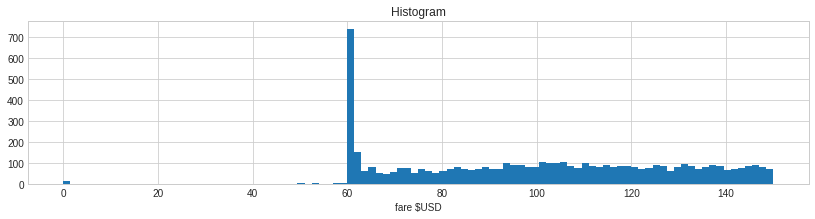

In [ ]:
train_df[train_df.fare<150].fare.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');


In [ ]:
train_df = pd.get_dummies(train_df, columns=['label'])
train_df = train_df.drop(['label_incorrect'],axis=1)


In [ ]:
# Get missing columns in the training test
missing_cols = set( train_df.columns ) - set( df_test.columns )
print(missing_cols)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0
    
missing_cols =  set( df_test.columns ) - set( train_df.columns )
print(missing_cols)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    train_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[train_df.columns]
df_test = df_test.drop(columns=['label_correct'])

{'label_correct'}
set()


In [ ]:
len(train_df[train_df['label_correct']==0].index)/len(train_df[train_df['label_correct']==1].index)

0.09882779612719383

In [ ]:
y = train_df['label_correct']
train = train_df.drop(columns=['label_correct'])
print(y.shape[0])
print(train_df.shape[0])


16967
16967


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=2,test_size=0.2, stratify=y)

# Traing Test

In [ ]:
%%time
model_train = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=5,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.624,
 seed=27)

# (
#  learning_rate =0.01,
#  n_estimators=1000,
#  max_depth=9,
#  min_child_weight=2,
#  gamma=0,
#  subsample=0.9,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)


model_train.fit(x_train,y_train)

CPU times: user 26.8 s, sys: 865 ms, total: 27.7 s
Wall time: 15.2 s


Acuracy 0.9566882734236889
f1_score 0.854339484487233


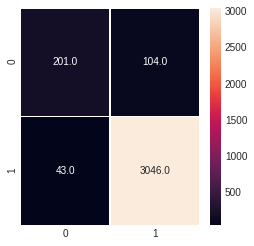

In [ ]:
xpt = model_train.predict(x_test)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, xpt), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

print('Acuracy',accuracy_score(y_test, xpt))
print('f1_score',f1_score(y_test, xpt, average='macro'))
# 0.8480273985865041 1
# 0.852374833080692 0.8
# 0.8587720898670687 0.6
# 0.8700215946672947 0.5
# 0.865729457455048 0.4
#  0.3

In [ ]:
y_pred = cross_val_predict(model_train, train,y, cv=10)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

print('Acuracy',accuracy_score(y, y_pred))
print('f1_score',f1_score(y, y_pred, average='macro'))

KeyboardInterrupt: ignored

# Parameter Tunig

In [ ]:
predictors = [x for x in train_df.columns if x not in [target, IDcol]]

param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
  'scale_pos_weight': [(5+i*0.1) for i in range(1,20)]
}

ptxgboost = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.8, reg_alpha=0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = ptxgboost , param_grid = param_test1, scoring='f1_macro',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_df[predictors],train_df[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
[(0.6+i*0.01) for i in range(1,13)]

In [ ]:
####################################################

# Traing Submition

In [ ]:
%%time
model_sub = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=5,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.65,
 seed=27)

model_sub.fit(train,y)

CPU times: user 33.1 s, sys: 901 ms, total: 34 s
Wall time: 18.6 s


In [ ]:
test_pred = model_sub.predict(df_test)
test_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
submission_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/sample_submission.csv", 
                            index_col="tripid")
submission_df

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1
...,...
222856243,1
222857785,0
222858416,0


In [ ]:
submission_df['prediction'] = test_pred

submission_df.to_csv('my_submission_daf.csv', index=True)

In [ ]:
submission_df[submission_df['prediction']==0 ]

,prediction
tripid,
213299545,0
213310068,0
213325248,0
213326731,0
213328890,0
...,...
222716573,0
222717033,0
222735934,0
